In [2]:
import sys

import numpy as np
sys.path.append('./')
sys.path.append('../')
from simulation.envs.TWLRobot import TWLRobot, TWLRReduccedObs
 

import gymnasium as gym

from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.evaluation import evaluate_policy

def make_env(rank: int, seed: int = 0):
    """
    Utility function for multiprocessed env.

    :param env_id: the environment ID
    :param num_env: the number of environments you wish to have in subprocesses
    :param seed: the initial seed for RNG
    :param rank: index of the subprocess
    """
    def _init():
        env = TWLRReduccedObs("../models/scene.xml", 4, termination_time = 4, time_first_reward = 4)
        env.goal = np.array([1, 0, 0.5])
        env._healthy_z_range = (0.4, 1)
        env.reset(seed=seed + rank)
        return env
    set_random_seed(seed)
    return _init

2024-08-29 12:25:23.767725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 12:25:23.783368: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 12:25:23.788249: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 12:25:24.477145: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
if __name__ == "__main__":

    termination_time = 4
    num_cpu = 4
    vec_env = SubprocVecEnv([make_env(i*0xAB0BA) for i in range(num_cpu)])
    vec_env_eval = SubprocVecEnv([make_env(i) for i in range(num_cpu)])
    obs = vec_env.reset()
    eval_log_dir = "./ppo_eval/"
    model = PPO("MlpPolicy", vec_env, verbose=1, tensorboard_log="./ppo_train_reduced/", device = "cpu", seed = 0xAB0BA)

    eval_callback = EvalCallback(vec_env_eval,
                              log_path=eval_log_dir, eval_freq=max(1000 // 4, 1), best_model_save_path="./coco_jambo/",
                              n_eval_episodes=2, deterministic=True,
                              render=False)
    
    model.learn(total_timesteps=600_000, progress_bar=True, tb_log_name="reduced", callback=eval_callback)

In [ ]:
model.save("./reduced_best_ppo2")
model.get_env()

In [14]:
model_best = PPO.load("./reduced_best_ppo")
 

one_env = TWLRReduccedObs("../models/scene.xml", 4, termination_time = 4, time_first_reward = 4)
one_env.goal = np.array([1, 0, 0.5])
one_env._healthy_z_range = (0.4, 1)
one_env.render_mode = "human"
obs, info = one_env.reset()
states = None
finish = True
goals = []
rewards = []
while finish:
    actions, states = model_best.predict(obs, deterministic=True)
    obs, reward, terminated, ttt, info = one_env.step(int(actions))
    finish  = not terminated
    goal_err = np.linalg.norm(info["direction_to_goal"])
    goals.append(goal_err)
    rewards.append(reward)

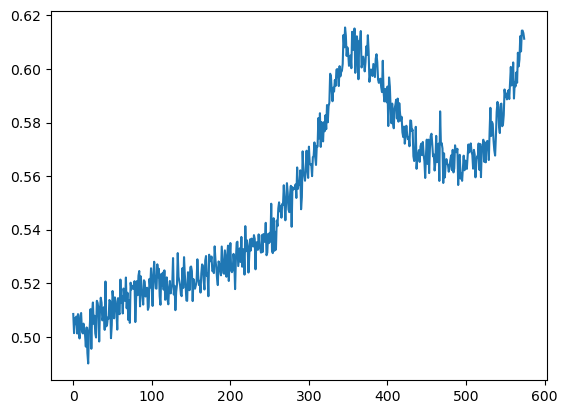

: 

In [15]:
import matplotlib.pyplot as plt
plt.plot(goals)
#plt.plot(rewards)

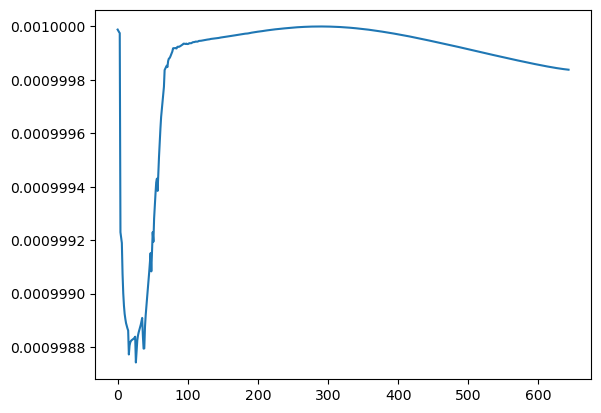

: 

In [20]:
plt.plot(rewards)
rew2 = [r*1000 for r in rewards]